In [1]:
### from molmap import loadmap
from joblib import load, dump
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, log_loss
import warnings, os
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from copy import copy
from tqdm import tqdm
from glob import glob

from aggmap.show import imshow, imshow_wrap
from aggmap.utils.matrixopt import smartpadding

warnings.filterwarnings("ignore")
os.environ["CUDA_VISIBLE_DEVICES"]="7"

In [2]:
from aggmap import loadmap
from fmp1 import CalcFeatImp, CalcFeatImpEach

In [3]:
flist = glob('../data/*.csv.gzip')
flist = pd.Series(flist).sort_values().tolist()
fall = []
for i in flist:
    df1 = pd.read_csv(i, compression='gzip', index_col = 0)
    df1['class'] = i.split('/')[-1].split('.csv')[0]
    fall.append(df1)
    
df = pd.concat(fall, axis=0)
dfy = df[df.columns[-1:]]

In [4]:
Y = pd.get_dummies(dfy['class']).values

In [5]:
res_save_folder = './X-AI'

In [6]:
#agg
mp = loadmap('/raid/shenwanxiang/agg_mp_object/pan-cancer.mp')

data_save_folder = '/raid/shenwanxiang/transcriptome/pan-cancer'
X1 = load(os.path.join(data_save_folder, 'Agg1.data'))

#cluster split channel
X5 = load(os.path.join(data_save_folder, 'Agg5.data'))

In [7]:
fold = 0
fold_num = "fold_%s" % str(fold).zfill(2) 
X = X5
save_path = '../fold_results_c5/%s' % fold_num
model = tf.keras.models.load_model(os.path.join(save_path, 'model.h5'))

2021-04-13 12:49:24,402 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-04-13 12:49:24,578 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 2001.71it/s]


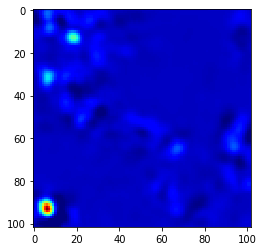

In [124]:
#for n, i, c in zip(image_idx, idx, clss):
i = 1
fontsize = 27
y = pd.DataFrame(Y, columns = range(Y.shape[-1]))
dfY = y.iloc[[i]]
arrX = X[[i]]
dfimp = CalcFeatImpEach(model, mp, arrX, dfY, apply_logrithm = False, apply_smoothing = True, sigma = 2, kernel_size=7)
IMPM = dfimp["imp"].values.reshape(mp._S.fmap_shape)
plt.imshow(IMPM, cmap = 'jet', vmin=-0.5)


# plot all class

In [ ]:
dfy = df[df.columns[-1:]]
label_idxs = dfy['class'].to_frame(name = 'labels').groupby('labels').apply(lambda x:x.index.to_list())

all_heatmap_values = []
seed = 256
image_names = [pd.Series(label_idxs[i]).sample(1, random_state = seed).to_list()[0] for i in range(len(label_idxs))]
dfy['idx'] = range(len(dfy))
idxes = dfy.loc[image_names]['idx'].to_list()
rows = dfy.loc[image_names]['class'].tolist()

fontsize = 24
fig, axes = plt.subplots(nrows=3, ncols=11, figsize=(25, 8), sharex = True, sharey = True)

for row, pid, ax, name in zip(rows, idxes, axes.ravel(), image_names):

    clas = row.split('_')[-1]
    pid_name = clas + '-' + str(pid)
    print(pid_name, pid, row)

    y = pd.DataFrame(Y, columns = range(Y.shape[-1]))
    dfY = y.iloc[[pid]]
    arrX = X[[pid]]
    dfimp = CalcFeatImpEach(model, mp, arrX, dfY, apply_logrithm = False, apply_smoothing = True, sigma = 2, kernel_size=7)
    IMPM = dfimp["imp"].values.reshape(mp._S.fmap_shape)
    ax.imshow(IMPM, cmap = 'jet', vmin = -0.1)    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(pid_name, fontdict = {'fontsize': fontsize})
    
    all_heatmap_values.append({'seed':seed, 'class':clas, 'idx':pid, 'name':name, 'h_value': IMPM})

fig.tight_layout()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.04, hspace=0.04)

fig.savefig('./XAI-local-%s.png' % seed, bbox_inches='tight', dpi=400) 


# plot the 10 class


CESC-1719 1719 04_CESC
CHOL-2028 2028 05_CHOL
ESCA-2449 2449 08_ESCA
GBM-2645 2645 09_GBM
KICH-3382 3382 11_KICH
KIRP-4079 4079 13_KIRP
LUSC-6104 6104 18_LUSC
MESO-6656 6656 19_MESO
READ-7970 7970 24_READ
UCS-10310 10310 32_UCS


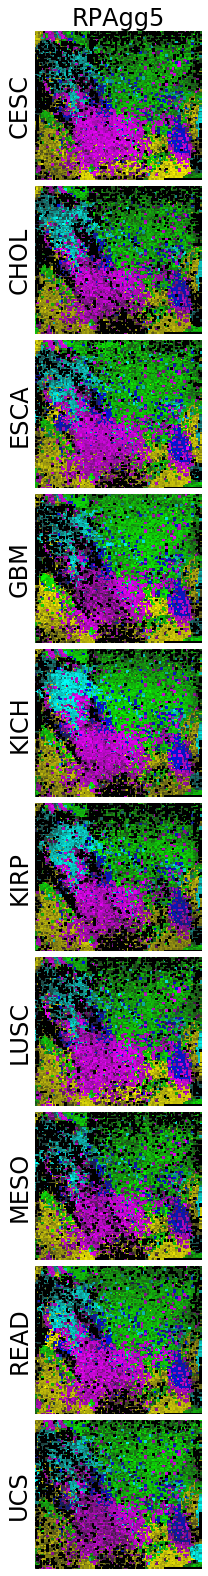

In [51]:
select = ['CESC', 'CHOL', 'ESCA', 'GBM', 'KICH', 'KIRP', 'LUSC', 'MESO', 'READ', 'UCS']
dfy = df[df.columns[-1:]]
label_idxs = dfy['class'].to_frame(name = 'labels').groupby('labels').apply(lambda x:x.index.to_list())
ss = [i for i in label_idxs.index if i.split('_')[-1] in select]
label_idxs = label_idxs.loc[ss]

all_heatmap_values = []
seed = 256
image_names = [pd.Series(label_idxs[i])[:2].sample(1, random_state = seed).to_list()[0] for i in range(len(label_idxs))]
dfy['idx'] = range(len(dfy))
idxes = dfy.loc[image_names]['idx'].to_list()
rows = dfy.loc[image_names]['class'].tolist()

fontsize = 24
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(3, 22), sharex = True, sharey = True)

for row, pid, ax1, name in zip(rows, idxes, axes.ravel(), image_names):

    clas = row.split('_')[-1]
    pid_name = clas + '-' + str(pid)
    print(pid_name, pid, row)

    y = pd.DataFrame(Y, columns = range(Y.shape[-1]))
    dfY = y.iloc[[pid]]
    arrX = X[[pid]]
    x = X[pid]
    
    imshow(x, ax = ax1,  mode = 'dark', color_list= pd.Series(mp.colormaps).tolist(), x_max=x.max()-0.05, vmin=-0.1, )
    
#     dfimp = CalcFeatImpEach(model, mp, arrX, dfY, apply_logrithm = False, apply_smoothing = True, sigma = 2, kernel_size=7)
#     IMPM = dfimp["imp"].values.reshape(mp._S.fmap_shape)
#     ax2.imshow(IMPM, cmap = 'jet', vmin = -0.1)    
    
    ax1.set_xticks([])
    ax1.set_yticks([])

    all_heatmap_values.append({'seed':seed, 'class':clas, 'idx':pid, 'name':name, 'h_value': IMPM})


axes[0].set_title('RPAgg5', fontdict = {'fontsize': fontsize})
    
rows = [row.split('_')[-1] for row in rows]
for ax, row in zip(axes, rows):
    ax.set_ylabel(row, fontsize = fontsize)    

fig.tight_layout()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.04, hspace=0.04) #

#fig.savefig('./XAI-local10-%s.png' % seed, bbox_inches='tight', dpi=400) 


CESC-1843 1843 04_CESC
2021-05-14 22:34:51,714 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-05-14 22:34:51,889 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1991.81it/s]


CHOL-2032 2032 05_CHOL
2021-05-14 22:35:11,862 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-05-14 22:35:12,019 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1939.14it/s]


ESCA-2498 2498 08_ESCA
2021-05-14 22:35:32,226 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-05-14 22:35:32,598 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:06<00:00, 1729.65it/s]


GBM-2763 2763 09_GBM
2021-05-14 22:35:55,428 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-05-14 22:35:55,881 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1744.99it/s]


KICH-3391 3391 11_KICH
2021-05-14 22:36:18,802 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-05-14 22:36:18,972 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:06<00:00, 1679.25it/s]


KIRP-4342 4342 13_KIRP
2021-05-14 22:36:42,289 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-05-14 22:36:42,712 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:06<00:00, 1652.61it/s]


LUSC-6313 6313 18_LUSC
2021-05-14 22:37:06,300 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-05-14 22:37:06,709 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:06<00:00, 1650.16it/s]


MESO-6665 6665 19_MESO
2021-05-14 22:37:30,808 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-05-14 22:37:30,969 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1791.53it/s]


READ-7999 7999 24_READ
2021-05-14 22:37:52,649 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-05-14 22:37:52,972 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1756.05it/s]


UCS-10355 10355 32_UCS
2021-05-14 22:38:16,419 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-05-14 22:38:16,852 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:06<00:00, 1704.33it/s]


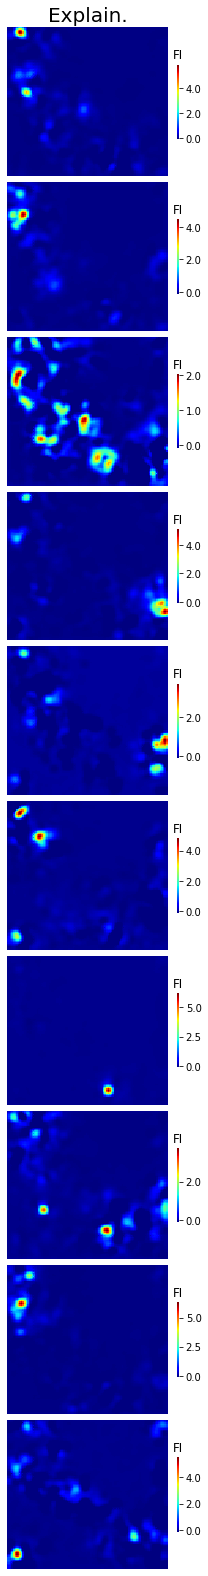

In [50]:
from matplotlib.ticker import FormatStrFormatter

select = ['CESC', 'CHOL', 'ESCA', 'GBM', 'KICH', 'KIRP', 'LUSC', 'MESO', 'READ', 'UCS']
dfy = df[df.columns[-1:]]
label_idxs = dfy['class'].to_frame(name = 'labels').groupby('labels').apply(lambda x:x.index.to_list())
ss = [i for i in label_idxs.index if i.split('_')[-1] in select]
label_idxs = label_idxs.loc[ss]

all_heatmap_values = []
seed = 256
image_names = [pd.Series(label_idxs[i]).sample(1, random_state = seed).to_list()[0] for i in range(len(label_idxs))]
dfy['idx'] = range(len(dfy))
idxes = dfy.loc[image_names]['idx'].to_list()
rows = dfy.loc[image_names]['class'].tolist()

fontsize = 20
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(3, 22), sharex = True, sharey = True)

for row, pid, ax1, name in zip(rows, idxes, axes.ravel(), image_names):

    clas = row.split('_')[-1]
    pid_name = clas + '-' + str(pid)
    print(pid_name, pid, row)

    y = pd.DataFrame(Y, columns = range(Y.shape[-1]))
    dfY = y.iloc[[pid]]
    arrX = X[[pid]]
    x = X[pid]
    
    #imshow(x, ax = ax1,  mode = 'dark', color_list= pd.Series(mp.colormaps).tolist(), x_max=x.max()-0.05, vmin=-0.1, )
    
    dfimp = CalcFeatImpEach(model, mp, arrX, dfY, apply_logrithm = False, apply_smoothing = True, sigma = 2, kernel_size=7)
    IMPM = dfimp["imp"].values.reshape(mp._S.fmap_shape)
    PCM = sns.heatmap(IMPM, cmap = 'jet', vmin = -0.1, ax=ax1,
                     cbar_kws = {'fraction':0.046, 
                                 'shrink':0.5, 
                                 'aspect': 40, 
                                 'pad':0.05, })    

    cbar = ax1.collections[0].colorbar
    cbar.ax.set_title('FI')
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    
    
    ax1.set_xticks([])
    ax1.set_yticks([])

    all_heatmap_values.append({'seed':seed, 'class':clas, 'idx':pid, 'name':name, 'h_value': IMPM})


axes[0].set_title('Explain.', fontdict = {'fontsize': fontsize})
    
# rows = [row.split('_')[-1] for row in rows]
# for ax, row in zip(axes.ravel(), rows):
#     ax.set_ylabel(row, fontsize = fontsize)    

fig.tight_layout()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.04, hspace=0.04) #

#fig.savefig('./XAI-local10-%s.png' % seed, bbox_inches='tight', dpi=400) 


# plot each class

In [19]:
{"BRCA":2, "CHOL":4, "READ":23, }  

{'CHOL': 4, 'READ': 23, 'KICH': 10}

03_BRCA
BRCA-506 506 03_BRCA
2021-04-13 14:46:53,259 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-04-13 14:46:53,465 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:06<00:00, 1730.40it/s]


BRCA-507 507 03_BRCA
2021-04-13 14:47:16,333 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-04-13 14:47:16,763 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1805.80it/s]


BRCA-508 508 03_BRCA
2021-04-13 14:47:39,014 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-04-13 14:47:39,405 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1880.45it/s]


BRCA-509 509 03_BRCA
2021-04-13 14:48:00,109 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-04-13 14:48:01,021 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1796.95it/s]


BRCA-510 510 03_BRCA
2021-04-13 14:48:22,928 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-04-13 14:48:23,106 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1863.03it/s]


BRCA-511 511 03_BRCA
2021-04-13 14:48:44,965 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-04-13 14:48:45,347 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1818.89it/s]


BRCA-512 512 03_BRCA
2021-04-13 14:49:06,706 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-04-13 14:49:07,121 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1847.05it/s]


BRCA-513 513 03_BRCA
2021-04-13 14:49:29,138 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-04-13 14:49:29,526 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1816.01it/s]


BRCA-514 514 03_BRCA
2021-04-13 14:49:50,768 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-04-13 14:49:51,176 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1833.93it/s]


11_KICH
KICH-3381 3381 11_KICH
2021-04-13 14:50:20,038 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-04-13 14:50:20,222 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1861.21it/s]


KICH-3382 3382 11_KICH
2021-04-13 14:50:41,230 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-04-13 14:50:41,410 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1972.16it/s]


KICH-3383 3383 11_KICH
2021-04-13 14:51:02,988 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-04-13 14:51:03,175 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1845.31it/s]


KICH-3384 3384 11_KICH
2021-04-13 14:51:25,372 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-04-13 14:51:25,559 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1823.53it/s]


KICH-3385 3385 11_KICH
2021-04-13 14:51:47,308 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-04-13 14:51:47,499 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1802.20it/s]


KICH-3386 3386 11_KICH
2021-04-13 14:52:09,155 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-04-13 14:52:09,335 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1793.44it/s]


KICH-3387 3387 11_KICH
2021-04-13 14:52:30,723 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-04-13 14:52:32,561 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1855.23it/s]


KICH-3388 3388 11_KICH
2021-04-13 14:52:54,699 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-04-13 14:52:54,888 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1865.77it/s]


KICH-3389 3389 11_KICH
2021-04-13 14:53:16,834 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-04-13 14:53:17,215 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1860.62it/s]


24_READ
READ-7969 7969 24_READ
2021-04-13 14:53:45,077 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-04-13 14:53:45,263 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1893.25it/s]


READ-7970 7970 24_READ
2021-04-13 14:54:06,896 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-04-13 14:54:07,075 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1875.40it/s]


READ-7971 7971 24_READ
2021-04-13 14:54:28,686 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-04-13 14:54:28,874 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1868.20it/s]


READ-7972 7972 24_READ
2021-04-13 14:54:50,763 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-04-13 14:54:50,947 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1816.68it/s]


READ-7973 7973 24_READ
2021-04-13 14:55:12,447 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-04-13 14:55:12,622 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1820.14it/s]


READ-7974 7974 24_READ
2021-04-13 14:55:34,799 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-04-13 14:55:34,972 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1873.84it/s]


READ-7975 7975 24_READ
2021-04-13 14:55:56,864 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-04-13 14:55:57,042 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1876.56it/s]


READ-7976 7976 24_READ
2021-04-13 14:56:19,309 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-04-13 14:56:19,497 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1847.83it/s]


READ-7977 7977 24_READ
2021-04-13 14:56:41,370 - INFO - [bidd-aggmap] - generate file: ./feature points_10381_correlation_umap_mp
2021-04-13 14:56:41,549 - INFO - [bidd-aggmap] - save html file to ./feature points_10381_correlation_umap_mp


100%|##########| 10404/10404 [00:05<00:00, 1858.40it/s]


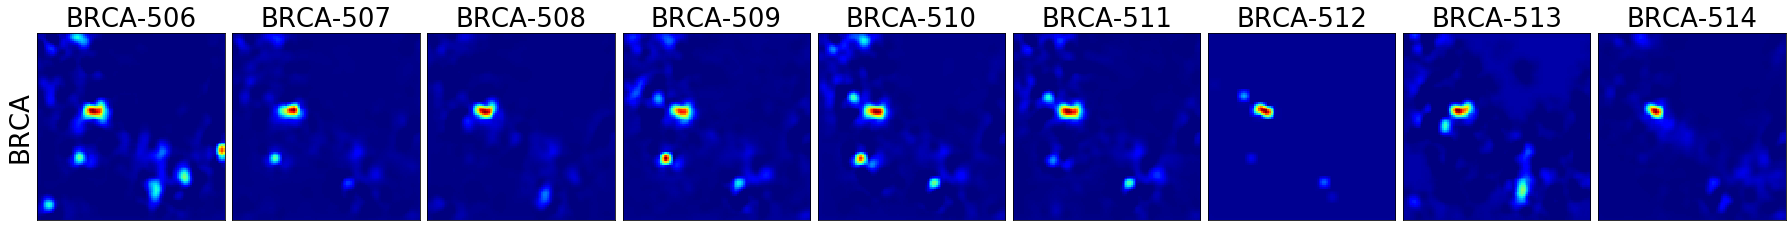

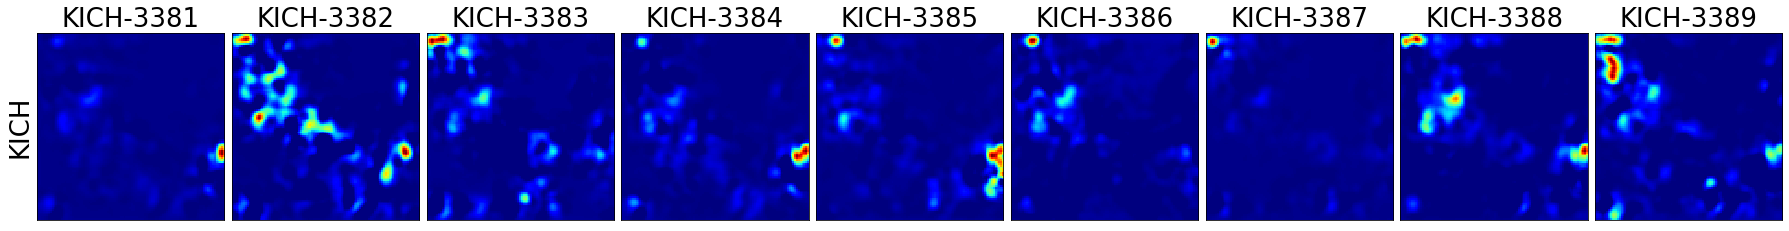

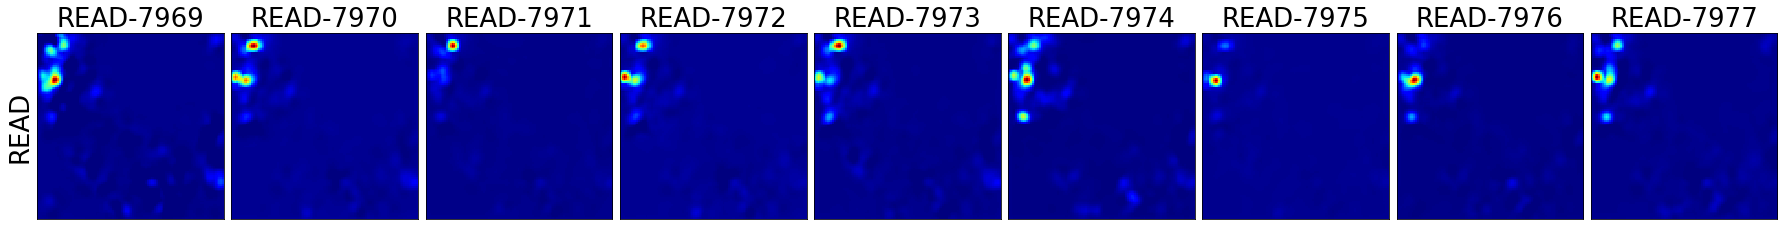

In [22]:
for select_class_idx in [2, 10, 23]:
    
    #select_class_idx = 4 #determinated which class

    n = 9 #how many individual samples

    seed = 0
    dfy = df[df.columns[-1:]]
    label_idxs = dfy['class'].to_frame(name = 'labels').groupby('labels').apply(lambda x:x.index.to_list())

    image_names = label_idxs.iloc[select_class_idx][:n]
    select_class= label_idxs.index[select_class_idx]
    print(select_class)


    dfy['idx'] = range(len(dfy))
    idxes = dfy.loc[image_names]['idx'].to_list()
    rows = dfy.loc[image_names]['class'].tolist()


    fontsize = 26
    fig, axes = plt.subplots(nrows=1, ncols=n, figsize=(25, 5), sharex = True, sharey = True)

    all_heatmap_values = []
    for row, pid, ax, name in zip(rows, idxes, axes.ravel(), image_names):

        clas = row.split('_')[-1]
        pid_name = clas + '-' + str(pid)
        print(pid_name, pid, row)

        y = pd.DataFrame(Y, columns = range(Y.shape[-1]))
        dfY = y.iloc[[pid]]
        arrX = X[[pid]]
        dfimp = CalcFeatImpEach(model, mp, arrX, dfY, apply_logrithm = False, apply_smoothing = True, sigma = 2, kernel_size=7)
        IMPM = dfimp["imp"].values.reshape(mp._S.fmap_shape)
        ax.imshow(IMPM, cmap = 'jet', vmin = -0.1)    
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(pid_name, fontdict = {'fontsize': fontsize})

        all_heatmap_values.append({'seed':seed, 'class':clas, 'idx':pid, 'name':name, 'h_value': IMPM})

    axes[0].set_ylabel(clas, fontsize = fontsize) 

    fig.tight_layout()

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.04, hspace=0.04)

    fig.savefig('./%s-local-%s.png' % (clas, pid), bbox_inches='tight', dpi=400) 
